In [1]:
import pandas as pd
import numpy as np
import os
import glob
import datetime

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Input
from sklearn import preprocessing

import tensorflow as tf
import tensorflow

import numpy as np
import os
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder



Using all the data, using a previous model to predict the auroral regions

In [2]:

file_load_df_cumulative = '../ParticlePrecipitation/ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
DMSP_DATA_DIR=''
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.sort_values(by=['ID_SC', 'Datetimes'])
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

cols_to_drop_validation = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop_validation = [c for c in df.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c) | ('newell' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]

df_cumulative = df_cumulative.drop(columns=cols_to_drop_validation)

# Separate training and testing data
mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])

# mask_for_2010_to_2014 = [(df_train.index.year == 2010) | (df_train.index.year == 2011)
#                          | (df_train.index.year == 2012) |(df_train.index.year == 2013)
#                          | (df_train.index.year == 2014)]
# df_train = df_train[mask_for_2010_to_2014[0]]
df_train = df_train.sort_values(by=['ID_SC', 'Datetimes'])
df_val = df_val.sort_values(by=['ID_SC', 'Datetimes'])

# Construct X and y
feature_cols = [c for c in df_train.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)
X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

In [3]:
from tensorflow.keras.layers import Input

input1 = Input(shape=(148))
model1 = Dense(256,  activation='relu')(input1)
model1 = model1 = Dropout(0.5)(model1)
model1 = Dense(64, activation='relu')(model1)
model1 = Dense(32, activation='relu')(model1)
model1 = Dense(int(256),   activation='relu')(model1)
model1 = Dense(int(1024),  activation='relu')(model1)
model1 = model1 = Dropout(0.2)(model1)
model1 = Dense(int(256),  activation='relu')(model1)
model1 = Dense(32, activation='relu')(model1)
model1 = Dense(4, activation='relu')(model1)
model1 = Dense(1, )(model1)


output = model1
model = tensorflow.keras.models.Model(inputs=input1, outputs=output)
#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 148)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               38144     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              263168

In [4]:

model.load_weights('all_years_flux_only_relu_dropout_best_epoch3.weights')

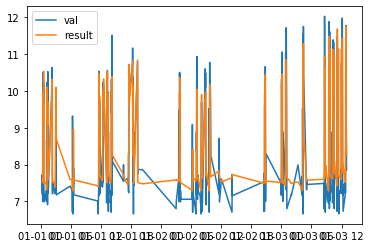

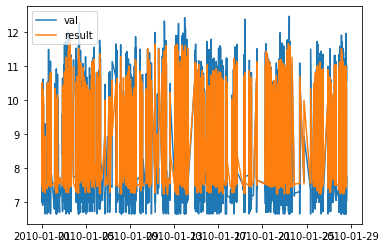

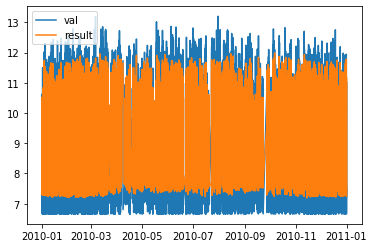

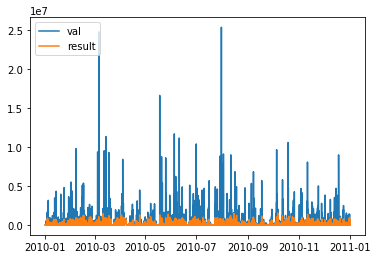

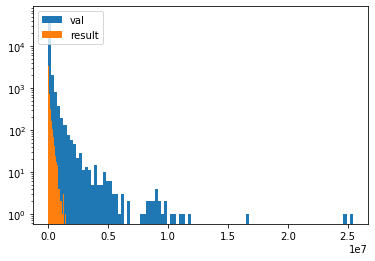

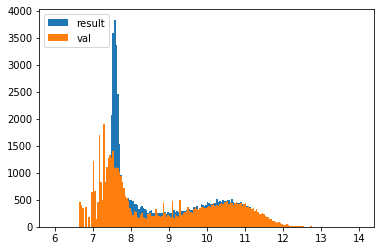

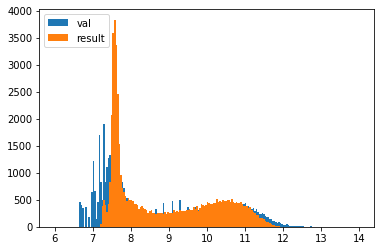

In [5]:
results = model.predict(X_test)



df_results = pd.DataFrame(data=results, index = df_val.index)

%matplotlib inline

plt.figure()
plt.plot(y_val_log[:500])
plt.plot(df_results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.plot(y_val_log[:5000])
plt.plot(df_results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()
plt.figure()
plt.plot(y_val_log[:])
plt.plot(df_results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.plot(10**y_val_log[:]*1.6e-6)
plt.plot(10**df_results[:]*1.6e-6)
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure()
plt.hist(10**y_val_log.values*1.6e-6,bins=100, log=True)
plt.hist(10**df_results.values*1.6e-6,bins=100, log=True)
plt.legend(['val', 'result'], loc='upper left')
plt.show()


plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.show()

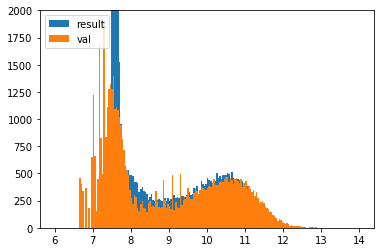

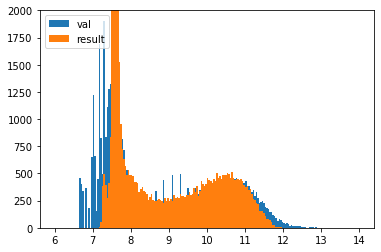

In [6]:
plt.figure()
plt.hist(df_results.values,bins=200,range=(6,14))
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.legend(['result','val'], loc='upper left')
plt.ylim([0,2000])
plt.show()

plt.figure()
plt.hist(y_val_log.values,bins=200,range=(6,14))
plt.hist(df_results.values,bins=200,range=(6,14))
plt.legend(['val', 'result'], loc='upper left')
plt.ylim([0,2000])

plt.show()

In [37]:
history = model.fit(X, 
                   y_train_log, 
                    validation_data=(
                        X_test, 
                        y_val_log,                                    ),
                    batch_size=32768,epochs=1000,verbose=2,
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  restore_best_weights=True,
             patience=100)])#

Epoch 1/1000
57/57 - 3s - loss: 18.7202 - val_loss: 3.0326
Epoch 2/1000
57/57 - 3s - loss: 2.5589 - val_loss: 2.2293
Epoch 3/1000
57/57 - 3s - loss: 1.5389 - val_loss: 2.1572
Epoch 4/1000
57/57 - 3s - loss: 1.4271 - val_loss: 2.0128
Epoch 5/1000
57/57 - 3s - loss: 1.3504 - val_loss: 1.8899
Epoch 6/1000
57/57 - 3s - loss: 1.2744 - val_loss: 1.6937
Epoch 7/1000
57/57 - 3s - loss: 1.2039 - val_loss: 1.5929
Epoch 8/1000
57/57 - 3s - loss: 1.1188 - val_loss: 1.4929
Epoch 9/1000
57/57 - 3s - loss: 1.0266 - val_loss: 1.2047
Epoch 10/1000
57/57 - 3s - loss: 0.9249 - val_loss: 1.0590
Epoch 11/1000
57/57 - 3s - loss: 0.8528 - val_loss: 1.0450
Epoch 12/1000
57/57 - 3s - loss: 0.8054 - val_loss: 1.0554
Epoch 13/1000
57/57 - 3s - loss: 0.7732 - val_loss: 0.9336
Epoch 14/1000
57/57 - 3s - loss: 0.7411 - val_loss: 0.8971
Epoch 15/1000
57/57 - 3s - loss: 0.7395 - val_loss: 0.8801
Epoch 16/1000
57/57 - 3s - loss: 0.7004 - val_loss: 0.8693
Epoch 17/1000
57/57 - 3s - loss: 0.6922 - val_loss: 0.8642
Epoch

Epoch 140/1000
57/57 - 3s - loss: 0.4512 - val_loss: 0.6633
Epoch 141/1000
57/57 - 3s - loss: 0.4512 - val_loss: 0.6345
Epoch 142/1000
57/57 - 3s - loss: 0.4502 - val_loss: 0.6731
Epoch 143/1000
57/57 - 3s - loss: 0.4525 - val_loss: 0.6426
Epoch 144/1000
57/57 - 3s - loss: 0.4489 - val_loss: 0.6593
Epoch 145/1000
57/57 - 3s - loss: 0.4490 - val_loss: 0.6741
Epoch 146/1000
57/57 - 3s - loss: 0.4484 - val_loss: 0.6499
Epoch 147/1000
57/57 - 3s - loss: 0.4519 - val_loss: 0.6299
Epoch 148/1000
57/57 - 3s - loss: 0.4486 - val_loss: 0.6641
Epoch 149/1000
57/57 - 3s - loss: 0.4517 - val_loss: 0.6377
Epoch 150/1000
57/57 - 3s - loss: 0.4464 - val_loss: 0.6327
Epoch 151/1000
57/57 - 3s - loss: 0.4474 - val_loss: 0.6558
Epoch 152/1000
57/57 - 3s - loss: 0.4474 - val_loss: 0.6251
Epoch 153/1000
57/57 - 3s - loss: 0.4459 - val_loss: 0.6205
Epoch 154/1000
57/57 - 3s - loss: 0.4477 - val_loss: 0.6360
Epoch 155/1000
57/57 - 3s - loss: 0.4473 - val_loss: 0.6391
Epoch 156/1000
57/57 - 3s - loss: 0.4455

Epoch 277/1000
57/57 - 3s - loss: 0.4228 - val_loss: 0.5776
Epoch 278/1000
57/57 - 3s - loss: 0.4231 - val_loss: 0.5797
Epoch 279/1000
57/57 - 3s - loss: 0.4233 - val_loss: 0.5945
Epoch 280/1000
57/57 - 3s - loss: 0.4226 - val_loss: 0.5716
Epoch 281/1000
57/57 - 3s - loss: 0.4225 - val_loss: 0.5845
Epoch 282/1000
57/57 - 3s - loss: 0.4215 - val_loss: 0.5759
Epoch 283/1000
57/57 - 3s - loss: 0.4218 - val_loss: 0.5733
Epoch 284/1000
57/57 - 3s - loss: 0.4223 - val_loss: 0.5741
Epoch 285/1000
57/57 - 3s - loss: 0.4221 - val_loss: 0.5836
Epoch 286/1000
57/57 - 3s - loss: 0.4230 - val_loss: 0.5779
Epoch 287/1000
57/57 - 3s - loss: 0.4219 - val_loss: 0.5809
Epoch 288/1000
57/57 - 3s - loss: 0.4213 - val_loss: 0.5889
Epoch 289/1000
57/57 - 3s - loss: 0.4223 - val_loss: 0.5848
Epoch 290/1000
57/57 - 3s - loss: 0.4221 - val_loss: 0.5689
Epoch 291/1000
57/57 - 3s - loss: 0.4221 - val_loss: 0.5818
Epoch 292/1000
57/57 - 3s - loss: 0.4207 - val_loss: 0.5914
Epoch 293/1000
57/57 - 3s - loss: 0.4210

Epoch 414/1000
57/57 - 3s - loss: 0.4112 - val_loss: 0.5696
Epoch 415/1000
57/57 - 3s - loss: 0.4107 - val_loss: 0.5828
Epoch 416/1000
57/57 - 3s - loss: 0.4109 - val_loss: 0.5750
Epoch 417/1000
57/57 - 3s - loss: 0.4110 - val_loss: 0.5778
Epoch 418/1000
57/57 - 3s - loss: 0.4104 - val_loss: 0.5752
Epoch 419/1000
57/57 - 3s - loss: 0.4109 - val_loss: 0.5857
Epoch 420/1000
57/57 - 3s - loss: 0.4105 - val_loss: 0.5743
Epoch 421/1000
57/57 - 3s - loss: 0.4111 - val_loss: 0.5715
Epoch 422/1000
57/57 - 3s - loss: 0.4109 - val_loss: 0.5736


In [38]:
# model.save('all_years_flux_only_relu_dropout_best_epoch3.model')
# model.save_weights('all_years_flux_only_relu_dropout_best_epoch3.weights')
# model.load_weights('all_years_flux_only_relu_dropout_best_epoch3.weights')